## Results generation for deep learning-based CBF generation with multi-PLD ASL

This notebook is organized by sections of code that generate the results or images in the Tables and Figures of the paper. Use the links below to jump to the relevant sections of the notebook (may only work in web browser Jupyter).

[Table 2](#table_2) |
[Figure 3A](#fig_3a) |
[Figure 3B](#fig_3b) |
[Figure 4](#fig_4) |
[Table 3](#table_3) |
[Figure 6](#fig_6)
<a id='top'></a>

In [1]:
import tensorflow as tf
from nilearn import plotting, image
import numpy as np
import matplotlib.pyplot as plt
import load_data
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
from statsmodels.stats.anova import AnovaRM
from funcs import *
%matplotlib inline

In [2]:
# Define base directories

project_dir = '/home/nluciw/home/projects/cbfnet/'
data_dir = project_dir + 'data/'

In [3]:
# Point to outputs of training and the files in the test set

output_dir = project_dir + 'output_dir/'
test_files = data_dir + 'study_datasets/test/'+'ge_test.txt'

In [4]:
# Get filenames, GM masks, and create X y dataset with removed PLDs

num_removed = range(5)

X_files, y_files = load_data.organize_filenames(test_files)

X_files = [file for file in X_files if 'asl.nii' in file]
y_files = [y_files[i] for i in range(0,len(y_files),4)]

ids = [name.split('/')[-2] for name in X_files]

masks = [data_dir + 'study_datasets/cbfnet_data/masks/sub-{}_T1w_brain_pve_1_flirt.nii.gz'.format(id) for id in ids]

datasets = [load_data.get_dataset(X_files, y_files, batch_size=1, 
                                  moments=data_dir+'study_datasets/cbfnet_data/moments.txt', 
                                  mask_num=i, shuffle=False)\
            for i in num_removed]

segs = [f[:-20]+'_T1w_brain_seg_flirt.nii.gz' for f in X_files]

In [5]:
# Get mean and std to scale the network outputs properly

moments = pd.read_csv(data_dir+'study_datasets/cbfnet_data/moments.txt', index_col=0)

In [6]:
# Get all trained models (including curriculum trained)

models = []
histories = []
mask_nums = range(4)
for j in mask_nums:
        with open(output_dir+'ge_model_mask{0}.json'.format(j)) as json_file:
            json_config = json_file.read()
        model = tf.keras.models.model_from_json(json_config)
        model.load_weights(output_dir+'ge_weights_mask{0}.h5'.format(j))
        models.append(model)
        with open(output_dir+'ge_history_mask{0}.json'.format(j), 'rb') as json_file:
            histories.append(pickle.load(json_file))

In [9]:
# Get inputs, network predictions for each network, and corresponding ground truths

inputs = []
for i in datasets[0].take(25):
    inputs.append(i[0][0].numpy())
    
predictions = []
for model in models:
    rem_preds = [model.predict(dataset) for dataset in datasets]
    predictions.append(rem_preds)
    
ground_truth = [i[1].numpy() for i in datasets[0].take(predictions[0][0].shape[0])]

In [8]:
# Create dataframe of metrics

df_mae = get_dframe(ground_truth, predictions, segs)
ssim_mae = get_dframe(ground_truth, predictions, masks, metric = 'ssim')

df = pd.concat((df_mae, ssim_mae))
dx_df = pd.DataFrame({'ID': df.ID.unique(), 'DX':['D','D', 'MCI', 'D', 'D', 'MCI', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'CU', 'CU', 'CU', 'CU', 'CU', 'D', 'CU']})

In [ ]:
# OPTIONAL: save niftis of vanilla network predictions

simple_pred = predictions[0][0]

ids = [f[0][-24:-20] for f in y_files]

with open(output_dir + 'test_ids.txt', 'w') as f:
    f.write('\n'.join(ids))

for pred, file in zip(simple_pred, y_files):
    im = image.new_img_like(file[0], pred[...,0]*92.)
    out_name = file[0][:-7] + '_pred.nii.gz'
    print(out_name)
    im.to_filename(out_name)

## Table 2: MAE (GM + WM) and SSIM overall
[Back to top](#top)
<a id='table_2'></a>

In [10]:
# Separate CBF and ATT into separate dataframes

cbf_df = df.loc[df.param=='CBF']
att_df = df.loc[df.param=='ATT']

cbf_df = pd.merge(cbf_df, dx_df, how='left', on='ID')
att_df = pd.merge(att_df, dx_df, how='left', on='ID')

In [11]:
# Get dataframes with only vanilla model

cbf_df_plain = cbf_df[cbf_df['PLDs dropped (training)']==0]
cbf_df_plain = cbf_df_plain[cbf_df_plain['PLDs Removed']==0]

att_df_plain = att_df[att_df['PLDs dropped (training)']==0]
att_df_plain = att_df_plain[att_df_plain['PLDs Removed']==0]

In [12]:
# Alter this cell to get the MAE and SSIM values for CBF and ATT written in the markdown cell below

cbf_df_plain[cbf_df_plain.metric=='ssim'].value.mean(), att_df_plain[att_df_plain.metric=='ssim'].value.mean()

(0.7839030429720879, 0.774886217713356)

CBF

GM MAE = 8.41 +- 1.44 WM MAE = 7.51 +- 1.86

SSIM = 0.78 +- 0.10 


ATT

GM MAE = 0.22 +- 0.09 WM MAE = 0.16 +- 0.07

SSIM = 0.77 +- 0.04

## Figure 2A: GM Ground truth vs network estimate
[Back to top](#top)
<a id='fig_3a'></a>

In [16]:
# Set figure aesthetic before figure generation

sns.set(style='whitegrid')

In [17]:
# Get the MNI atlas registered to individual images
mni_atlases = [f[:-20]+'_MNI-atlas_GM-masked.nii.gz' for f in X_files]

In [18]:
# Use the atlases to get regional values for cbf + att
seg_cbf_values = [get_atlas_values(ground_truth[i][0], predictions[0][0][i], mni_atlases[i], 
                                    scaling=92., avg=True) for i in range(len(mni_atlases))]
seg_att_values = [get_atlas_values(ground_truth[i][0], predictions[0][0][i], mni_atlases[i], 
                                    scaling=1.36, param='att', avg=True) for i in range(len(mni_atlases))]

seg_cbfs = pd.concat(seg_cbf_values)
seg_atts = pd.concat(seg_att_values)

In [19]:
# Combine diagnosis info with metrics and estimates

seg_cbfs = pd.merge(seg_cbfs, dx_df, how='left', on='ID')

seg_atts = pd.merge(seg_atts, dx_df, how='left', on='ID')

In [20]:
# Enter magnetic field strength into dataframe

b0 = ['3' if int(x)>3999 else '1.5' for x in seg_cbfs.ID]
seg_cbfs['B0'] = b0

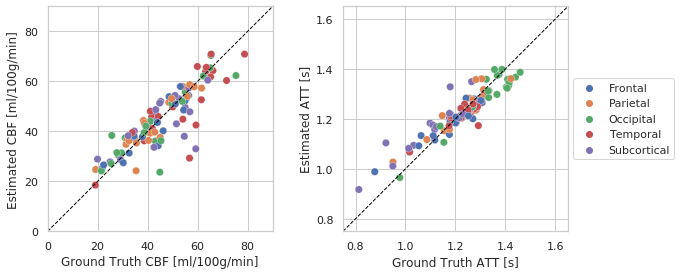

In [21]:
# Plot alternative Figure 2A: GT vs network estimates

fig, ax = plt.subplots(1,2,figsize=[10,7])

# Plot CBF
sns.scatterplot(x='gt', y='pred', hue='Tissue type', data=seg_cbfs, alpha=1., 
                ax=ax[0], s=55, palette=sns.color_palette()[:5], linewidth=0.3)
ax[0].plot([0,90], [0,90], '--', c='black', lw=1.)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].set_aspect('equal', 'box')

ax[0].set_ylim([0,90])
ax[0].set_xlim([0,90])
ax[0].set_xticks([0,20,40,60,80])
ax[0].set_yticks([0,20,40,60,80])

ax[0].set_xlabel('Ground Truth CBF [ml/100g/min]')
ax[0].set_ylabel('Estimated CBF [ml/100g/min]')

ax[0].get_legend().remove()

# Plot ATT
sns.scatterplot(x='gt', y='pred', hue='Tissue type', data=seg_atts, alpha=1., 
                ax=ax[1], s=55, palette=sns.color_palette()[:5], linewidth=0.3)
ax[1].plot([0.75,1.65], [0.75,1.65], '--', c='black', lw=1.)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[1:], labels=['Frontal', 'Parietal', 'Occipital', 'Temporal', 'Subcortical'], loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_aspect('equal', 'box')

ax[1].set_ylim([0.75,1.65])
ax[1].set_xlim([0.75,1.65])
ax[1].set_xticks([0.80,1.,1.2,1.4, 1.6])
ax[1].set_yticks([0.80,1.,1.2,1.4, 1.6])

ax[1].set_xlabel('Ground Truth ATT [s]')
ax[1].set_ylabel('Estimated ATT [s]')

fig.tight_layout(pad=2.2)

#fig.savefig(output_dir + 'region_scatter_w-dx.pdf')

In [22]:
seg_atts.groupby(by='Tissue type').mean()

,gt,pred,diff,param
Tissue type,,,,
Frontal,1.183241,1.187833,0.179793,1
Occipital,1.332771,1.302083,0.246723,1
Parietal,1.244920,1.248386,0.156468,1
Subcortical,1.139907,1.185430,0.158898,1
Temporal,1.231425,1.218688,0.295656,1


In [23]:
seg_atts.groupby(by='Tissue type').std()

,gt,pred,diff,param
Tissue type,,,,
Frontal,0.099793,0.072186,0.067560,0.0
Occipital,0.118061,0.108420,0.109544,0.0
Parietal,0.101591,0.084811,0.070739,0.0
Subcortical,0.136078,0.104548,0.130938,0.0
Temporal,0.063256,0.045909,0.147413,0.0


## Figure 2B: MAE by field strength
[Back to top](#top)
<a id='fig_3b'></a>

In [24]:
cbf_15T = cbf_df_plain[(cbf_df_plain.metric=='mae') & (cbf_df_plain['Field Strength']==1.5)].value
cbf_3T = cbf_df_plain[(cbf_df_plain.metric=='mae') & (cbf_df_plain['Field Strength']==3.0)].value

att_15T = att_df_plain[(att_df_plain.metric=='mae') & (att_df_plain['Field Strength']==1.5)].value
att_3T = att_df_plain[(att_df_plain.metric=='mae') & (att_df_plain['Field Strength']==3.0)].value

In [25]:
stats.ttest_rel(cbf_15T, cbf_3T)

Ttest_relResult(statistic=-3.043088372129413, pvalue=0.013948016285467447)

In [26]:
stats.wilcoxon(att_15T, att_3T)

WilcoxonResult(statistic=25.0, pvalue=0.7988593499960496)

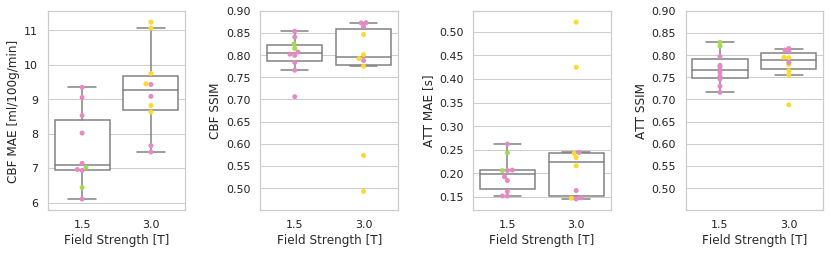

In [27]:
# Plot Figure 2B: performance metrics as function of field strength

fig, ax = plt.subplots(1,4, figsize=(12,4))

# Plot CBF MAE then ATT MAE
sns.boxplot(x='Field Strength', y='value', data=cbf_df_plain[cbf_df_plain.metric=='mae'], ax=ax[0], fliersize=0, palette=['m','g'])
sns.swarmplot(x='Field Strength', y='value', hue='DX', data=cbf_df_plain[cbf_df_plain.metric=='mae'], 
              ax=ax[0], size=5, linewidth=0, palette=sns.color_palette('Set2')[3:6])
ax[0].set_ylabel('CBF MAE [ml/100g/min]')
ax[0].set_xlabel('Field Strength [T]')
ax[0].get_legend().remove()

sns.boxplot(x='Field Strength', y='value', data=att_df_plain[att_df_plain.metric=='mae'], ax=ax[2], fliersize=0, palette=['m','g'])
sns.swarmplot(x='Field Strength', y='value', hue='DX', data=att_df_plain[att_df_plain.metric=='mae'], 
              ax=ax[2], size=5, linewidth=0, palette=sns.color_palette('Set2')[3:6])
ax[2].set_ylabel('ATT MAE [s]')
ax[2].set_xlabel('Field Strength [T]')
ax[2].get_legend().remove()

# Plot CBF SSIM then ATT SSIM
sns.boxplot(x='Field Strength', y='value', data=cbf_df_plain[cbf_df_plain.metric=='ssim'], ax=ax[1], fliersize=0, palette=['m','g'])
sns.swarmplot(x='Field Strength', y='value', hue='DX', data=cbf_df_plain[cbf_df_plain.metric=='ssim'], 
              ax=ax[1], size=5, linewidth=0, palette=sns.color_palette('Set2')[3:6])
ax[1].set_ylabel('CBF SSIM')
ax[1].set_xlabel('Field Strength [T]')
ax[1].set_yticks(np.linspace(0.50, 0.90, 9, endpoint=True))
ax[1].set_ylim([0.45,0.9])
ax[1].get_legend().remove()

sns.boxplot(x='Field Strength', y='value', data=att_df_plain[att_df_plain.metric=='ssim'], ax=ax[3], fliersize=0, palette=['m','g'])
sns.swarmplot(x='Field Strength', y='value', hue='DX', data=att_df_plain[att_df_plain.metric=='ssim'], 
              ax=ax[3], size=5, linewidth=0, palette=sns.color_palette('Set2')[3:6])
ax[3].set_ylabel('ATT SSIM')
ax[3].set_xlabel('Field Strength [T]')
ax[3].set_yticks(np.linspace(0.50, 0.90, 9, endpoint=True))
ax[3].set_ylim([0.45,0.9])
ax[3].get_legend().remove()

# Set boxplots to grey colouring
for axx in ax.flatten():
# iterate over boxes
    for i,box in enumerate(axx.artists):
        box.set_edgecolor('grey')
        box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             axx.lines[j].set_color('grey')

fig.tight_layout(pad=2.0)

#fig.savefig(output_dir + 'b0_performance_vanilla_model_w-dx.pdf')

## Figure 3: Plot axial slices of images (with MAE values)
[Back to top](#top)
<a id='fig_4'></a>

In [28]:
# Use this cell and the cell below to find individuals with representative and highest MAE

cbf_df_plain[cbf_df_plain.metric=='mae']

,ID,value,metric,param,PLDs dropped (training),Network,PLDs Removed,Field Strength,DX
0,1276,8.017445,mae,CBF,0,CNN,0,1.5,D
1,1293,9.051885,mae,CBF,0,CNN,0,1.5,D
2,1303,6.436565,mae,CBF,0,CNN,0,1.5,MCI
3,1311,9.347318,mae,CBF,0,CNN,0,1.5,D
4,1318,6.959279,mae,CBF,0,CNN,0,1.5,D
5,1344,7.013841,mae,CBF,0,CNN,0,1.5,MCI
6,1350,7.138902,mae,CBF,0,CNN,0,1.5,D
7,1359,8.528211,mae,CBF,0,CNN,0,1.5,D
8,1381,6.102023,mae,CBF,0,CNN,0,1.5,D
9,1435,6.931752,mae,CBF,0,CNN,0,1.5,D


In [66]:
# Get the MAE and SSIM for the individuals with representative and highest MAE

cbf_df_plain[cbf_df_plain.ID == str(4023)]

,ID,value,metric,param,PLDs dropped (training),Network,PLDs Removed,Field Strength,DX
12,4023,9.084340,mae,CBF,0,CNN,0,3.0,D
412,4023,0.864029,ssim,CBF,0,CNN,0,3.0,D


1.5 T Worst CBF: 1311 (idx 3 mae 9.35 ssim 0.80)
1.5 T Representative CBF: 1435 (idx 9 mae 6.93 ssim 0.84)

3T Worst CBF: 4060 (idx 19 mae 11.24 ssim 0.493)
3T Representative CBF: 4023 (idx 12 mae 9.08 ssim 0.864)

[Text(1, 0, '0'),
 Text(1, 0, '25'),
 Text(1, 0, '50'),
 Text(1, 0, '75'),
 Text(1, 0, '100'),
 Text(1, 0, '125')]

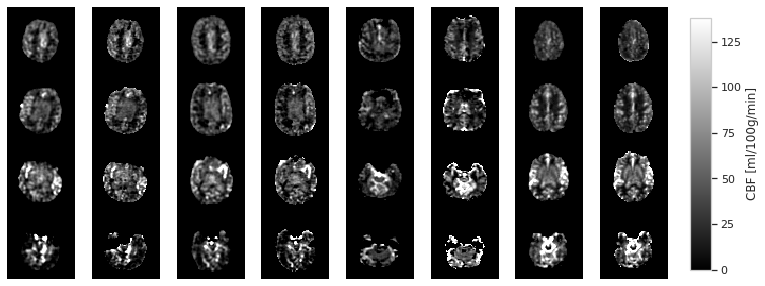

In [29]:
'''Plot the axial slices for CBF net estimate and ground truth
for all four of representative and highest MAE for 1.5T and 3T'''

model_num = 0
individual = 3
num_rem = 0
param = 0
fig, ax = plt.subplots(4,8, figsize=(12,5))
for i in range(4):
    ax[3-i,0].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,0].axis('off')
    ax[3-i,1].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,1].axis('off')

individual = 9
    
for i in range(4):
    ax[3-i,2].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,2].axis('off')
    ax[3-i,3].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,3].axis('off')

individual = 19
    
for i in range(4):
    ax[3-i,4].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,4].axis('off')
    ax[3-i,5].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,5].axis('off')
    
individual = 12
    
for i in range(4):
    ax[3-i,6].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,6].axis('off')
    im=ax[3-i,7].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,7].axis('off')
    
plt.subplots_adjust(hspace=0.00, wspace=0.1, right =0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, label='CBF [ml/100g/min]', ticks=[0,0.272,0.5435,0.8152,1.087,1.3587])
cbar.ax.set_yticklabels(['0','25','50','75', '100', '125'])
#fig.savefig(output_dir + 'cbf_images.pdf')

In [68]:
# Use this cell to get the MAE and SSIM values for the ATT images for the individuals identified above

att_df_plain[att_df_plain.ID == str(4023)]

,ID,value,metric,param,PLDs dropped (training),Network,PLDs Removed,Field Strength,DX
12,4023,0.145286,mae,ATT,0,CNN,0,3.0,D
412,4023,0.809073,ssim,ATT,0,CNN,0,3.0,D


1.5 T Worst ATT: 1311 (idx 3 mae 0.193 ssim 0.730)
1.5 T Representative ATT: 1435 (idx 9 mae 0.151 ssim 0.773)

3T Worst ATT: 4060 (idx 19 mae 0.521 ssim 0.688)
3T Representative ATT: 4023 (idx 12 mae 0.145 ssim 0.809)

[Text(1, 0, '0.0'),
 Text(1, 0, '0.4'),
 Text(1, 0, '0.8'),
 Text(1, 0, '1.2'),
 Text(1, 0, '1.6'),
 Text(1, 0, '2.0')]

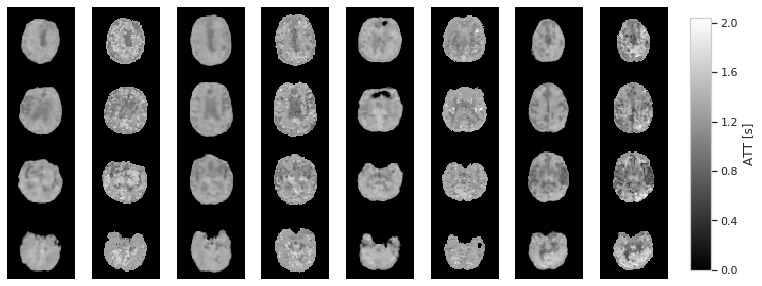

In [23]:
'''Plot the axial slices for ATT net estimate and ground truth
for all four of representative and highest MAE for 1.5T and 3T'''

model_num = 0
individual = 3
num_rem = 0
param = 1
fig, ax = plt.subplots(4,8, figsize=(12,5))
for i in range(4):
    ax[3-i,0].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,0].axis('off')
    ax[3-i,1].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,1].axis('off')

individual = 9
    
for i in range(4):
    ax[3-i,2].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,2].axis('off')
    ax[3-i,3].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,3].axis('off')

individual = 19
    
for i in range(4):
    ax[3-i,4].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,4].axis('off')
    ax[3-i,5].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,5].axis('off')
    
individual = 12
    
for i in range(4):
    ax[3-i,6].imshow(np.rot90(predictions[model_num][num_rem][individual,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,6].axis('off')
    ax[3-i,7].imshow(np.rot90(ground_truth[individual][0,:,:,4*i,param], axes=(0,1)),vmin=0.,vmax=1.5, cmap='gray')
    ax[3-i,7].axis('off')
    
plt.subplots_adjust(hspace=0.00, wspace=0.1, right =0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, label='ATT [s]', ticks=[0,0.2941,0.5882,0.8824,1.1765,1.4706])
cbar.ax.set_yticklabels(['0.0','0.4','0.8','1.2', '1.6', '2.0'])

#fig.savefig(output_dir + 'att_images.pdf')

## Figure 5: Curriculum-trained vs vanilla model
[Back to top](#top)
<a id='fig_6'></a>

In [30]:
# Select the models trained on up to 0 and 3 PLDs removed (i.e. the standard model and the full curr. trained)

cbf_2models = cbf_df[(cbf_df['PLDs dropped (training)'] == 0 )| (cbf_df['PLDs dropped (training)'] == 3)]
att_2models = att_df[(att_df['PLDs dropped (training)'] == 0 )| (att_df['PLDs dropped (training)'] == 3)]

In [31]:
# Get only MAE metric

cbf_2models_mae = cbf_2models[cbf_2models.metric=='mae']
att_2models_mae = att_2models[att_2models.metric=='mae']

In [32]:
# Caution... hacky :)
# Grab test results from inputs with missing images for both models

cbf_model0_rem0 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==0) & (cbf_2models_mae['PLDs dropped (training)']==0)]
cbf_model0_rem1 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==1) & (cbf_2models_mae['PLDs dropped (training)']==0)]
cbf_model0_rem2 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==2) & (cbf_2models_mae['PLDs dropped (training)']==0)]
cbf_model0_rem3 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==3) & (cbf_2models_mae['PLDs dropped (training)']==0)]

cbf_model3_rem0 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==0) & (cbf_2models_mae['PLDs dropped (training)']==3)]
cbf_model3_rem1 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==1) & (cbf_2models_mae['PLDs dropped (training)']==3)]
cbf_model3_rem2 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==2) & (cbf_2models_mae['PLDs dropped (training)']==3)]
cbf_model3_rem3 = cbf_2models_mae[(cbf_2models_mae['PLDs Removed']==3) & (cbf_2models_mae['PLDs dropped (training)']==3)]

In [33]:
att_model0_rem0 = att_2models_mae[(att_2models_mae['PLDs Removed']==0) & (att_2models_mae['PLDs dropped (training)']==0)]
att_model0_rem1 = att_2models_mae[(att_2models_mae['PLDs Removed']==1) & (att_2models_mae['PLDs dropped (training)']==0)]
att_model0_rem2 = att_2models_mae[(att_2models_mae['PLDs Removed']==2) & (att_2models_mae['PLDs dropped (training)']==0)]
att_model0_rem3 = att_2models_mae[(att_2models_mae['PLDs Removed']==3) & (att_2models_mae['PLDs dropped (training)']==0)]

att_model3_rem0 = att_2models_mae[(att_2models_mae['PLDs Removed']==0) & (att_2models_mae['PLDs dropped (training)']==3)]
att_model3_rem1 = att_2models_mae[(att_2models_mae['PLDs Removed']==1) & (att_2models_mae['PLDs dropped (training)']==3)]
att_model3_rem2 = att_2models_mae[(att_2models_mae['PLDs Removed']==2) & (att_2models_mae['PLDs dropped (training)']==3)]
att_model3_rem3 = att_2models_mae[(att_2models_mae['PLDs Removed']==3) & (att_2models_mae['PLDs dropped (training)']==3)]

In [34]:
# Get dataframes for only curr trained model for 0->3 PLDs removed

dfm3 = pd.concat([cbf_model3_rem0,cbf_model3_rem1,cbf_model3_rem2,cbf_model3_rem3])
dfm3 = dfm3.rename(columns = {'PLDs Removed':'pld_rem'})

att_dfm3 = pd.concat([att_model3_rem0,att_model3_rem1,att_model3_rem2,att_model3_rem3])
att_dfm3 = att_dfm3.rename(columns = {'PLDs Removed':'pld_rem'})

In [35]:
# Print out stats results for CBF

print(stats.wilcoxon(cbf_model0_rem3.value, cbf_model3_rem3.value))

a = AnovaRM(dfm3, depvar='value', subject='ID', within=['pld_rem'])
print(a.fit())

WilcoxonResult(statistic=0.0, pvalue=8.857457687863547e-05)
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
pld_rem  1.7010 3.0000 57.0000 0.1770



In [36]:
# Print out stats for ATT

a = AnovaRM(att_dfm3, depvar='value', subject='ID', within=['pld_rem'])
b = stats.friedmanchisquare(att_model3_rem0.value,att_model3_rem1.value,att_model3_rem2.value,att_model3_rem3.value)
print(a.fit(), b)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
pld_rem 12.7888 3.0000 57.0000 0.0000
 FriedmanchisquareResult(statistic=19.920000000000016, pvalue=0.00017634704848790446)


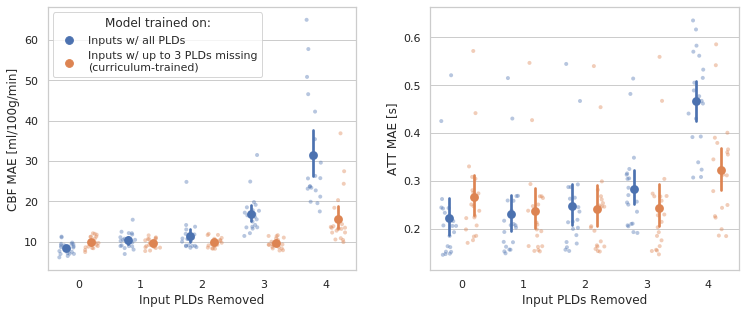

In [37]:
# Plot Figure 5

#CBF plot
fig, ax = plt.subplots(1,2,figsize=(11,5))
pt = sns.pointplot(x='PLDs Removed', y='value', hue='PLDs dropped (training)', 
            kind='point', join=False, data=cbf_2models[cbf_2models.metric=='mae'], dodge=0.4, ax=ax[0])
g = sns.stripplot(x='PLDs Removed', y='value', hue='PLDs dropped (training)', 
                  data=cbf_2models[cbf_2models.metric=='mae'], ax=ax[0], dodge=0.3, alpha=0.4, size=4, jitter=0.25)
ax[0].set_ylabel('CBF MAE [ml/100g/min]')
ax[0].set_xlabel('Input PLDs Removed')

#ATT plot
sns.stripplot(x='PLDs Removed', y='value', hue='PLDs dropped (training)', 
              data=att_2models[att_2models.metric=='mae'], ax=ax[1], dodge=0.3, alpha=0.4, size=4, jitter=0.25)
sns.pointplot(x='PLDs Removed', y='value', hue='PLDs dropped (training)', 
            kind='point', join=False, data=att_2models[att_2models.metric=='mae'], dodge=0.4, ax=ax[1])
ax[1].set_ylabel('ATT MAE [s]')
ax[1].set_xlabel('Input PLDs Removed')
ax[1].get_legend().remove()

# Legend plot
legend_title = 'Model trained on:'
labels = ['Inputs w/ all PLDs', 'Inputs w/ up to 3 PLDs missing\n(curriculum-trained)']
for t, l in zip(ax[0].get_legend().texts, labels): t.set_text(l)
fig.tight_layout(pad=2.5)
handles, _ = plt.gca().get_legend_handles_labels() 
l = ax[0].legend(handles[0:2], labels, title=legend_title)

#fig.savefig(output_dir + 'pld_performance_point.pdf')

## Make colourbars for various figures

/Users/nicholas/environments/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


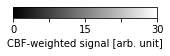

In [70]:
a = np.array([[0,1]])
plt.figure(figsize=(2.5, 0.6))
img = plt.imshow(a, cmap="gray")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.7, 0.8, 0.25])
c = plt.colorbar(orientation="horizontal", cax=cax)
c.set_label('CBF-weighted signal [arb. unit]')
_ = c.ax.set_xticklabels(['0', '', '15','','30'])
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.)
plt.savefig(output_dir + 'cbfw_cbar30.pdf')

/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


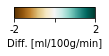

In [50]:
a = np.array([[0,1]])
plt.figure(figsize=(1.5, 0.9))
img = plt.imshow(a, cmap="BrBG")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.78, 0.75, 0.1667])
c = plt.colorbar(orientation="horizontal", cax=cax)
c.set_label(r'Diff. [ml/100g/min]')
_ = c.ax.set_xticklabels(['-2', '', '2'])
plt.tight_layout(pad=2)
plt.savefig(output_dir + 'diff_cbar.pdf')

/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Use the colorbar set_ticks() method instead.
  
/home/nluciw/environments/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Remove the CWD from sys.path while we load stuff.


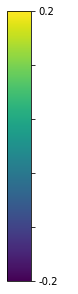

In [60]:
a = np.array([[0,1]])
plt.figure(figsize=(2, 5))
img = plt.imshow(a, cmap="viridis")
plt.gca().set_visible(False)
cax = plt.axes([0.3, 0.1, 0.1667, 0.75])
c = plt.colorbar(orientation="vertical", cax=cax)
c.set_label(r' ')
c.ax.set_yticks([0.,0.5,1.])
_ = c.ax.set_yticklabels(['-0.2', '', '', '' , '', '0.2'])
plt.tight_layout(pad=2)
plt.savefig(output_dir + 'cbf_filter-cbar.pdf')